# Case Study 1: Predicting Location via Indoor Positioning Systems (IPS)
## MSDS 7333: Quantifying the World
### Andy Nguyen, Michael Wolfe, Josepha Caguioa

## Objective
The floor plan for the building shows six access points. However, the data contain seven access points with roughly the expected number of signals (166 location 8 orientations 110 replications 146,080 measurements). Two of the MAC addresses seem to be for the same access point. Measurements from the MAC address 00:0f:a3:39:e1:c0 were kept while measurements to the 00:0f:a3:39:dd:cd address were eliminated. Conduct a more thorough data analysis into these two MAC addresses. Did we make the correct decision? Does swapping out the one we kept for the one we discarded improve the prediction?

### Guidelines

Using the OFFLINE data and **2 different clustering methods**, predict the location of the ONLINE dataset.

1. Describe how you prepared the data.
2. Describe how you estimated your error and found the best fit ASSUMING you CANNOT USE THE ONLINE DATA. Use tables and/or charts with analysis.
3. Describe the best fit for the data using tables and/or charts with analysis.
4. There are 2 macIDs located at the same position (the researchers used 00:0f:a3:39:e1:c0 and excluded 00:0f:a3:39:dd:cd for their analysis). Does one give better performance than the other?
    * Note: to effectively answer the below, you’d need to run (3) different scenarios (this aligns to question 9 from the text; page 41)
5. What about using them both? (compare the result of “c0 & cd” against “c0-only” and “cd-only”)
6. What are the drawback (if any of using this method to real-time locate an object)?
7. Describe a method that may be an improvement based on your perceived drawbacks.


**Datasets** <br>
http://rdatasciencecases.org/Data/offline.final.trace.txt <br>
http://rdatasciencecases.org/Data/online.final.trace.txt


### Data Description
* signal strength measurements are recorded between wireless hand-held device and routers
* floor plan of test environment measures [15 meters x 36 meters]; measurments were only taken in the hallway

* offline synonyomous with training data, but more accurately described as reference data of signal strength measurements at known locations
    
    * signal strength measured using a hand-held device at 166 different locations spaced 1 meter apart **(gray dots)**
    routers
    * router locations are located at 6 WiFi access points **(black squares)**
    
    * reference locations (x,y) coordinates of the hand-held device were each recorded in 45 degree increments for 8 different orientations
    * 110 signal strength measurements recorded to each of the 6 routers for all location-oritentation combinations
    
* online synonymous with test data; use the model built on the offline data to predict location of new unknown devices based on detected signals

    * 60 location-orientation pairs were randomly selected on the floor (black dots)
        *   110 signals measured from these sampled positions to each router 
        
<br>
<center><img src = "http://www.rdatasciencecases.org/GeoLoc/images/building.png"></center>
<br>

Training a model on data based on reference locations provides calibrated signal strength measurements at those locations within the environment, which will be used to predict the location of hand-held devices at uncalibrated positions.

**Note: Not all signal strengths were measured at every location. Measurements from other hand-held devices in the vicinity of the experimental unit also appear.**

#### Feature Description

* t: timestamp in milliseconds since midnight, January 1, 1970 UTC
* id: MAC address of the scanning device
* pos: the physical coordinate of the scanning device
* degree: oritentaion of the user carrying the scanning device in degrees
* MAC address: address of device with corresponding values for signal strength in (dBm), channel frequency (1-3), and mode (1)
    * a unique identifier that allows network cards in computer, access points, or other wireless equipment identified on the network

### Pre-Process Data

In [1]:
import rpy2.ipython
%load_ext rpy2.ipython

OSError: cannot load library 'C:\Users\micha\Anaconda3\envs\qtw\lib\R\bin\x64\R.dll': error 0x7e

In [2]:
%%time
%%R 
# DO NOT NEED TO RUN THIS CELL IF FILE ALREADY EXITS IN WORKING DIRECTORY

library(tidyverse)
library(magrittr)
# Parser Function that returns matricies of measured signal strengths
processLine = 
  function(x) {
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
  
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
  }

roundOrientation = 
  function(angles) {
  refs = seq(0, by = 45, length = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
  }

processData = 
  function(filename)
  { # read in data from file
    txt = readLines(filename)
    # subset original offline text data to remove all lines with comments
    lines = txt[ substr(txt, 1, 1) != "#" ]
    # apply parser function to every line in the text file
    tmp = lapply(lines, processLine)
    # cast parsed data into data frame 
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    # assign variable names to data features
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
    # Remove all adhoc type measurements from data frame
    # Analysis will only include signal strengths measured to fixed access points
    offline = offline[ offline$type == "3", ]
    
    # Drop scanMac, posZ, channel, and type (contain no useful info)
    # only 1 value for scanMac, the MAC for the hand-held device
    # posZ = 0 for all measurements since they were all taken on the same floor
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # There are 12 unqiue MAC addresses and 8 channels
    # keep records from top 7 devices, since there is a large drop in number of signals after (>100,000)
    # channels removed b/c one-to-one correspondence between MAC addresses and channels for remaining 7 devices
    keepMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
    offline = offline[ offline$mac %in% keepMacs, ]
    
    # # convert attributes to appropriate data types (numeric)
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # Format time to POSIXt - change scale from milliseconds to seconds
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # Round orientations to nearest 45 degree increment
    offline$orientation = roundOrientation(offline$orientation)

    return(offline)
  }

offline = processData("http://rdatasciencecases.org/Data/offline.final.trace.txt")
online = 
# Save Processed data into csv that can be read into python as a pandas dataframe 
write.csv(offline, file = 'offlineOutput.csv')

Wall time: 3min 23s


In [3]:
# Read in processed data as pandas dataframe
import pandas as pd
import numpy as np
csvFile_R = pd.read_csv("offlineOutput.csv")
# Remove index column
csvFile_R = csvFile_R.drop(columns=["Unnamed: 0"])
# create categorical factor levels for each mac address of fixed access points
csvFile_R['mac'] = csvFile_R['mac'].astype("category")
# cast time stamp column as date-time type
csvFile_R['time'] = pd.to_datetime(csvFile_R['time'])

In [4]:
# Cast data frame to have mac values and their associated signal strengths in the columns
# Aggregate positions by time
position = csvFile_R.groupby('rawTime')['posX','posY','orientation'].mean()
# Get aggreagated time stamps
time = csvFile_R.groupby('rawTime')['time'].unique()
# Pivot dataframe to wide format with mac addresses as feature columns aggregated by time
macSignals = pd.pivot_table(csvFile_R, index = 'rawTime', columns = "mac", values = "signal", aggfunc = np.mean)
# Merge aggregated positions with wide format data frame of mac addresses
offline = pd.merge(position,macSignals,on='rawTime')
# Insert time stamp for measurements in wide-formatted data frame
offline.insert(10, "time", time)

C:\Users\micha\Anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
offline

,posX,posY,orientation,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90,time
rawTime,,,,,,,,,,,
1139643118358,0,0,0,-75.0,-53.0,-66.0,-65.0,-38.0,-65.0,-56.0,[2006-02-10T23:31:58.000000000]
1139643118744,0,0,0,-73.0,-54.0,-67.0,-66.0,-38.0,-70.0,-56.0,[2006-02-10T23:31:58.000000000]
1139643119002,0,0,0,-65.0,-54.0,-69.0,-66.0,-38.0,-70.0,-57.0,[2006-02-10T23:31:59.000000000]
1139643119263,0,0,0,-78.0,-54.0,-68.0,-64.0,-38.0,-74.0,-52.0,[2006-02-10T23:31:59.000000000]
1139643119538,0,0,0,-66.0,-55.0,-67.0,-66.0,-46.0,NaN,-57.0,[2006-02-10T23:31:59.000000000]
...,...,...,...,...,...,...,...,...,...,...,...
1141936869448,20,8,315,-76.0,-51.0,NaN,NaN,-60.0,-56.0,-69.0,[2006-03-09T12:41:09.000000000]
1141936869700,20,8,315,-77.0,-53.0,-52.0,-58.0,-61.0,-62.0,NaN,[2006-03-09T12:41:09.000000000]
1141936869952,20,8,315,-77.0,-54.0,-58.0,-62.0,-60.0,-56.0,-69.0,[2006-03-09T12:41:09.000000000]


In [6]:
offline.describe()

,posX,posY,orientation,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
count,146074.000000,146074.000000,146074.000000,144251.000000,145778.000000,120770.000000,117502.000000,121662.000000,117611.000000,119383.000000
mean,14.247094,5.915741,157.500000,-70.433231,-53.701096,-60.525549,-56.257156,-56.584270,-53.764808,-66.996122
std,10.566967,2.673878,103.108844,8.107942,5.793654,7.045726,7.959090,9.583506,8.291848,10.643820
min,0.000000,0.000000,0.000000,-98.000000,-92.000000,-90.000000,-87.000000,-88.000000,-93.000000,-93.000000
25%,3.000000,3.000000,56.250000,-77.000000,-58.000000,-65.000000,-61.000000,-64.000000,-60.000000,-76.000000
50%,13.000000,7.000000,180.000000,-71.000000,-54.000000,-61.000000,-56.000000,-58.000000,-54.000000,-69.000000
75%,23.000000,8.000000,258.750000,-64.000000,-50.000000,-56.000000,-51.000000,-50.000000,-48.000000,-58.000000
max,33.000000,13.000000,315.000000,-46.000000,-34.000000,-38.000000,-29.000000,-26.000000,-25.000000,-34.000000


In [8]:
csvFile_R = pd.read_csv("Data/onlineOutput.csv")
# Remove index column
csvFile_R = csvFile_R.drop(columns=["Unnamed: 0"])
# create categorical factor levels for each mac address of fixed access points
csvFile_R['mac'] = csvFile_R['mac'].astype("category")
# cast time stamp column as date-time type
csvFile_R['time'] = pd.to_datetime(csvFile_R['time'])
# Cast data frame to have mac values and their associated signal strengths in the columns
# Aggregate positions by time
position = csvFile_R.groupby('rawTime')['posX','posY','orientation'].mean()
# Get aggreagated time stamps
time = csvFile_R.groupby('rawTime')['time'].unique()
# Pivot dataframe to wide format with mac addresses as feature columns aggregated by time
macSignals = pd.pivot_table(csvFile_R, index = 'rawTime', columns = "mac", values = "signal", aggfunc = np.mean)
# Merge aggregated positions with wide format data frame of mac addresses
online = pd.merge(position,macSignals,on='rawTime')
# Insert time stamp for measurements in wide-formatted data frame
online.insert(10, "time", time)
online

C:\Users\micha\Anaconda3\envs\qtw\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


,posX,posY,orientation,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90,time
rawTime,,,,,,,,,,,
1139692477303,0.00,0.05,135,-64.0,-52.0,-62.0,-58.0,-43.0,-62.0,-57.0,[2006-02-11T15:14:37.000000000]
1139692477555,0.00,0.05,135,-62.0,-52.0,NaN,NaN,-43.0,-64.0,-57.0,[2006-02-11T15:14:37.000000000]
1139692477807,0.00,0.05,135,-66.0,-51.0,-62.0,-68.0,-44.0,NaN,-49.0,[2006-02-11T15:14:37.000000000]
1139692478059,0.00,0.05,135,-66.0,-52.0,-68.0,NaN,-39.0,-63.0,-58.0,[2006-02-11T15:14:38.000000000]
1139692478311,0.00,0.05,135,-61.0,-51.0,-59.0,-60.0,-42.0,-64.0,NaN,[2006-02-11T15:14:38.000000000]
...,...,...,...,...,...,...,...,...,...,...,...
1141928790747,21.45,6.62,45,-72.0,-53.0,-62.0,-48.0,-57.0,-42.0,-69.0,[2006-03-09T12:26:30.000000000]
1141928790999,21.45,6.62,45,-72.0,-53.0,-61.0,NaN,-59.0,-38.0,NaN,[2006-03-09T12:26:30.000000000]
1141928791251,21.45,6.62,45,-72.0,-52.0,-60.0,-55.0,-59.0,NaN,NaN,[2006-03-09T12:26:31.000000000]


### Gaussian Mixture Model

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture
import itertools

for c in offline:
    offline[c]=offline[c].fillna(0)
    
for c in online:
    online[c]=online[c].fillna(0)

TypeError: '(array([False, False, False, ...,  True,  True,  True]), 0)' is an invalid key

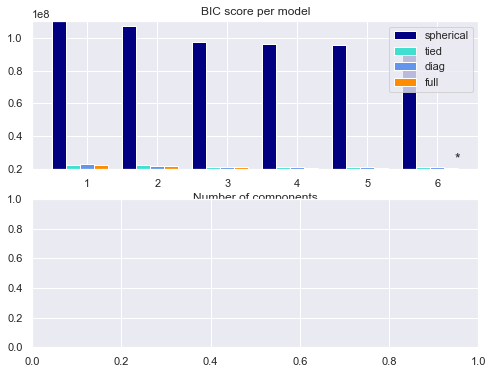

In [30]:
X=offline
Y=online
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(Y)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = np.linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()